## Getting the input as an image type
The cell below creates and ensures the existence of the specific sample path.
The image of the sample can be downloaded through a link as of the cell below "drp_url", or added seperately as a file.

**For this specific sample:** 
    - Binary image data obtained from the filtered grayscale image data. The grayscale image was segmented at threshold level 71 calculated using the IsoData algorithm. For more details, please refer to the related publications.
Segmented Yes Voxel length (x, y, z) 2.25, 2.25, 2.25 um Link: https://www.digitalrocksportal.org/projects/317/origin_data/1380/

Image Type 8-bit Width 1000 Height 1000 Number of Slices 1000 Byte Order little-endian

we assummed voxel_size=1, and we can postprocess units of the predictions by multiplying the results by **[voxel_size]**. However, PoreSpy's functions can accept the value of voxel_size to prevent post-processing step

In [1]:
import subprocess
import os
import numpy as np
import porespy as ps
import h5py  # if there was error importing, please install the h5py package
import importlib
import warnings
import openpnm as op
import porespy as ps
import scipy as sp
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score
import time
import tensorflow as tf

2023-03-23 18:37:01.045466: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Ensure the existence of model path, and create one if non-existant

In [7]:

if not os.path.exists("sf-model-lib"):
    !git clone https://github.com/PMEAL/sf-model-lib

In the cell below we the proper library and assign the weights 

In [8]:

h5tools = importlib.import_module("sf-model-lib.h5tools")
DIR_WEIGHTS = "sf-model-lib/diffusion"
fname_in = [f"{DIR_WEIGHTS}/model_weights_part{j}.h5" for j in [0, 1]]

#Identifying hdf5 files and merging them together, the result would be a unique file
h5tools.combine(fname_in, fname_out=f"{DIR_WEIGHTS}/model_weights.h5")

The cell below, we import are related libraries (these chould be installed before usage) 
Then we start the training of the model and load the wieghts

In [9]:

ps.visualization.set_mpl_style()
warnings.filterwarnings("ignore")
path_AI = "./sf-model-lib/diffusion"
path_train = os.path.join(path_AI, 'g_train_original.hdf5')
path_weights = os.path.join(path_AI, 'model_weights.h5')
g_train = h5py.File(path_train, 'r')['g_train'][()]


2023-03-23 18:37:30.467161: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[18:37:32] WARNING  `lr` is deprecated, please use `learning_rate` instead, or use the legacy      ]8;id=905709;file:///home/anaconda/mambaforge/envs/tensorflow_env/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py\optimizer.py]8;;\:]8;id=489667;file:///home/anaconda/mambaforge/envs/tensorflow_env/lib/python3.9/site-packages/keras/optimizers/optimizer_experimental/optimizer.py#106\106]8;;\
                    optimizer, e.g.,tf.keras.optimizers.legacy.Adam.                                               

In [1]:

# save the binary image as hdf5
# TODO: double checking the names
path='rock_sample_Leopard'# this is the path folder for saving the data for this example
if not os.path.isdir(path):
    os.makedirs(path)
def download_geometry(filename, url):

    download_command = f'wget {url} -O {filename}'
    try:
        subprocess.run(download_command.split(' '))
    except FileNotFoundError:
        raise InterruptedError(f'wget was not found. Please make sure it is installed on your system.')
    return
drp_url = 'https://www.digitalrocksportal.org/projects/317/images/223481/download/' # I found this link from selecting action
# button next to the image, download and right click>copy link.
file_name = path+'/image_Leopard.raw'
#download_geometry(file_name, drp_url)

## Convertion to Numpy array
After importing the input image, we need to define the voxels(dimensions of the sample),
this information is usually gathered from the source of the image.
Next step is to convert the image data to numpy arrays for easier mathematical computation.
the line ***(ps.metrics.porosity(im))*** is to check the porosity level to the information from the input source description. If not, you may need to switch False and True in the above code or replace 0 with a different value. You can check the current values in the loaded image using np.unique(im).

More info on np.from [file](https://numpy.org/doc/1.21/reference/generated/numpy.fromfile.html#:~:text=numpy.fromfile%20%C2%B6%20numpy.fromfile%28file%2C%20dtype%3Dfloat%2C%20count%3D-%201%2C%20sep%3D%27%27%2C%20offset%3D0%2C,as%20well%20as%20parsing%20simply%20formatted%20text%20files)

In [2]:

# TODO: checking size and names
voxelsx = 1000
voxelsy = 1000
voxelsz = 1000
path= 'rock_sample_Leopard'
voxel_size = 2.25e-6
im = np.fromfile(path+'/image_Leopard.raw', dtype="<i1")
im = np.reshape(im, (voxelsx,voxelsy,voxelsz)) # this value may need to be changed based on input image size

# make sure pore space is True and solid is False
pore_space = im == 0 # sometimes this may be 255 or some other value
im[pore_space] = True
im[~pore_space] = False
print(ps.metrics.porosity(im))

0.195033838


## Slicing the image
In this stage we slice the image to smaller pieces. This is to speed up the process of prediction with the AI approach and the DNS approach.

In [3]:
im = im[:100,:100,:100]

## Segmentation of the image
Snow function is developed as part of the PoreSPY opensource package, Snow extracts pore and conns from the image.
We then extract the pore network of the porous medium image using PoreSpy's snow2 algorithm. snow2 returns the segmented image of the porous medium as well as extracted network data.

In [4]:
snow = ps.networks.snow2(im, boundary_width=0, parallelization=None, voxel_size = voxel_size)
regions = snow.regions
net = snow.network
conns = net['throat.conns']

0it [00:00, ?it/s]

Extracting pore and throat properties:   0%|          | 0/73 [00:00<?, ?it/s]

In [ ]:
model = ps.networks.create_model()

# Giving the path weights to .load function

model.load_weights(path_weights)

Finally we intiate the AI prediction process

**Note:** This cell is often the longest to exute


In [12]:
predicted_ai = ps.networks.diffusive_size_factor_AI(
    regions,
    model=model,
    g_train=g_train,
    throat_conns=conns,
    voxel_size = voxel_size
)

Preparing images tensor:   0%|          | 0/122 [00:00<?, ?it/s]

8/8 [==============================] - 9s 932ms/step


Similarly we run the DNS(Direct Numerical Simulation)

In [13]:

startTime = time.time()
predicted_dns = ps.networks.diffusive_size_factor_DNS(regions,
                                                    throat_conns=conns,
                                                         voxel_size = voxel_size)
executionTime_dns = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime_dns))

Preparing images and DNS calculations:   0%|          | 0/122 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Getting ROI info:   0%|          | 0/2 [00:00<?, ?it/s]

Execution time in seconds: 100.3078281879425


Now that you have the region, you can use it for prediction. 

Once the values are predicted, you can save them ih hdf5 format for later use. 

For example:
    
    The cell below creates the datasets (Float type) of "predicted_ai" values

Similarly we create the dataset for "predicted_dns" values

The cell below plots a 2D demosntration of the 3D image on 2 respected exes if added 0

[:,:,0] plots an image on x-y plane, while [:,0,:] plots the image on x-z plane


Finally we plot the Comparison between AI results and DNS predicted results.

This helps us to understand the deviation between the two and also mesaure the accuracy and the correctness of the results

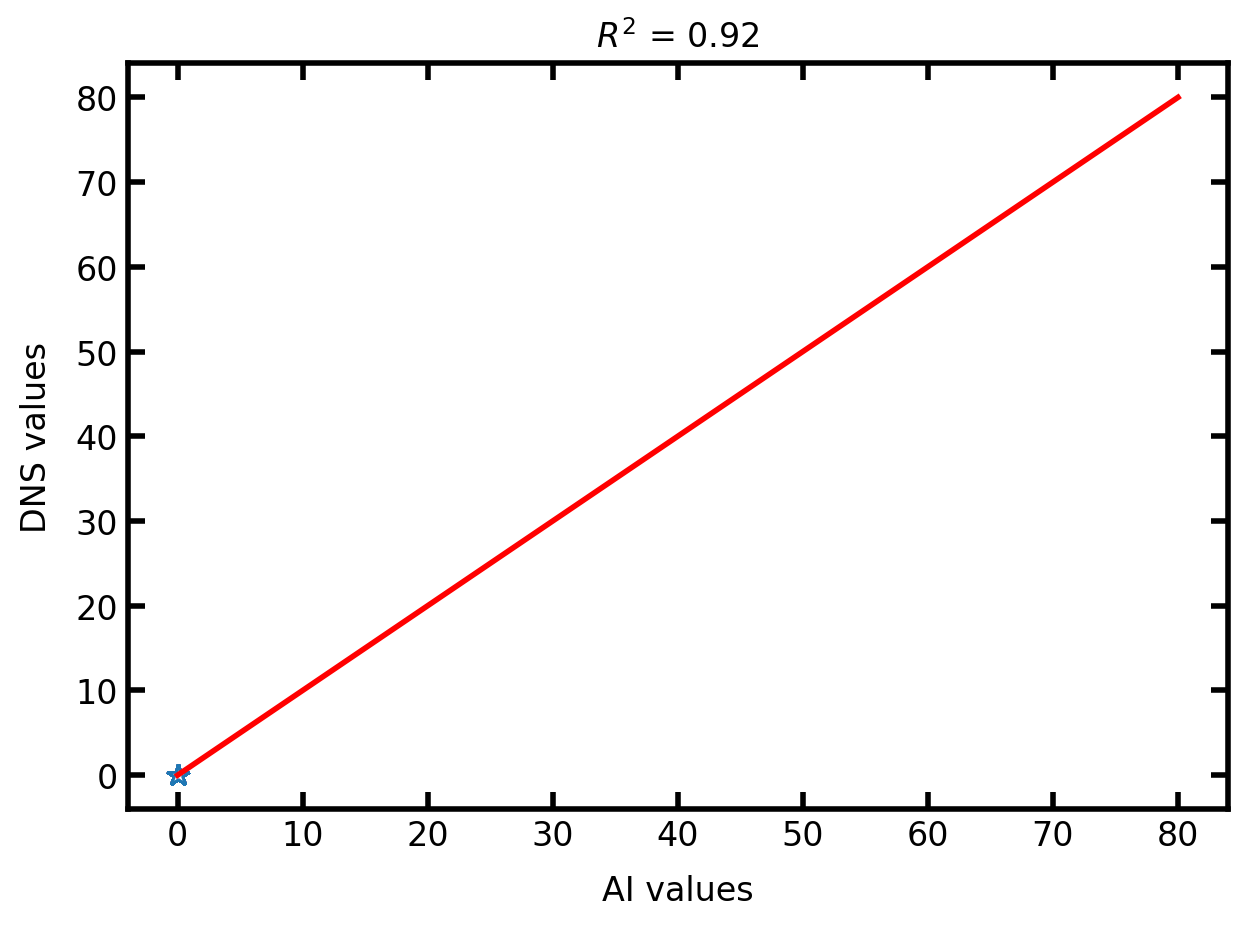

In [19]:

# plt.plot(Ai_values, DNS_values, '*')
plt.plot(Ai_values, DNS_values, '*', [0, 80], [0, 80], 'r')
plt.title(r'$R^2$ = ' + str(np.round(r2_score(DNS_values, Ai_values), 2)));
plt.xlabel('AI values')
plt.ylabel('DNS values')
plt.savefig(path+'/prediction')